In [58]:
import pandas as pd
import os
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from colorspacious import cspace_convert
import colorsys
import matplotlib

In [59]:
path=r'D:\DLR\minitest\babylogger14'
folder=os.listdir(path)
folder.sort()

In [60]:
df = pd.read_csv(path+'\\'+folder[0], skiprows=18, header=None, sep=r'\s+')
column_names=['time','gx','gy','gz','ax','ay','az']
df.columns = column_names
xx=np.zeros(len(df['ax']))
xx[:len(df['ax'])]=np.array(df['ax'])
yy=np.zeros(len(df['ay']))
yy[:len(df['ay'])]=np.array(df['ay'])
zz=np.zeros(len(df['az']))
zz[:len(df['az'])]=np.array(df['az'])
output=np.c_[xx,yy, zz]

(0.0, 319.9807692307692)

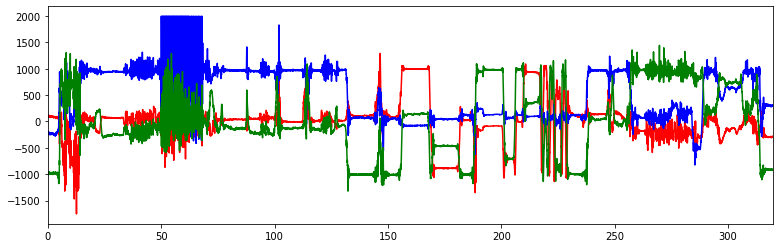

In [61]:
xlabel=np.arange(len(xx))/52
plt.figure(figsize=(13, 4))
plt.plot(xlabel,xx,c='r')
plt.plot(xlabel,yy,c='b')
plt.plot(xlabel,zz,c='g')
plt.xlim(0,np.max(xlabel))

In [62]:
def low_pass_filter(data, cutoff=0.25, fs=52.0, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

In [63]:
accel_filtered = np.array([low_pass_filter(output[:, i]) for i in range(3)]).T/100

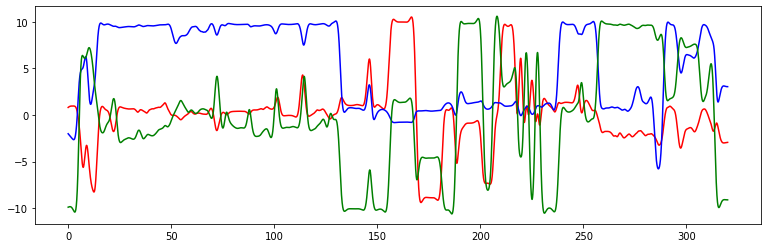

In [64]:
xlabel=np.arange(len(accel_filtered[:,0]))/52
plt.figure(figsize=(13, 4))
plt.plot(xlabel,accel_filtered[:,0],c='r')
plt.plot(xlabel,accel_filtered[:,1],c='b')
plt.plot(xlabel,accel_filtered[:,2],c='g')

In [65]:
# Signal vector magnitude (SVM) calculation
def calculate_svm(accel_data):
    return np.abs(np.sqrt(np.sum(accel_data**2, axis=1))-9.8)

In [66]:
svm_ga = calculate_svm(accel_filtered)

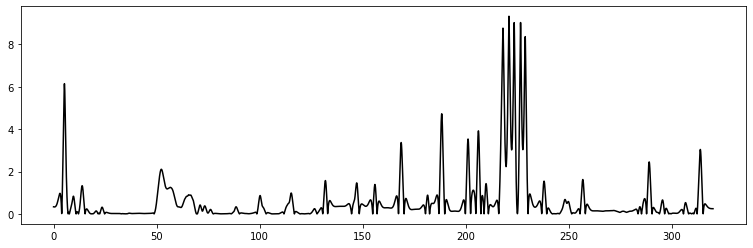

In [67]:
xlabel=np.arange(len(svm_ga))/52
plt.figure(figsize=(13, 4))
plt.plot(xlabel,svm_ga,c='k')

In [68]:
trunk_angle=np.degrees(np.arctan2(accel_filtered[:,2], accel_filtered[:,1]))

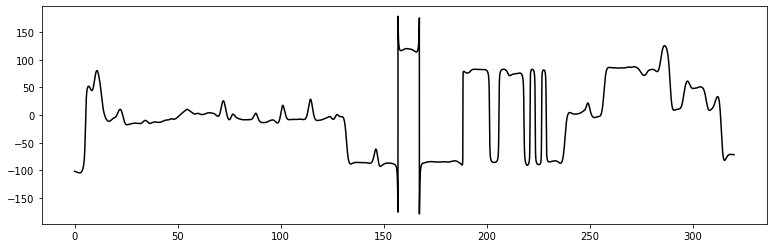

In [69]:
xlabel=np.arange(len(trunk_angle ))/52
plt.figure(figsize=(13, 4))
plt.plot(xlabel,trunk_angle ,c='k')

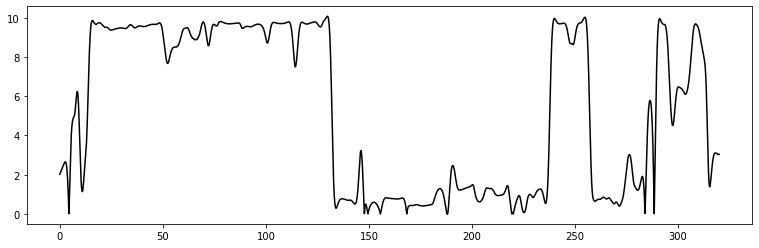

In [70]:
xlabel=np.arange(len(accel_filtered[:, 1]))/52
plt.figure(figsize=(13, 4))
plt.plot(xlabel,np.abs(accel_filtered[:, 1]) ,c='k')
#plt.ylim(0,2)

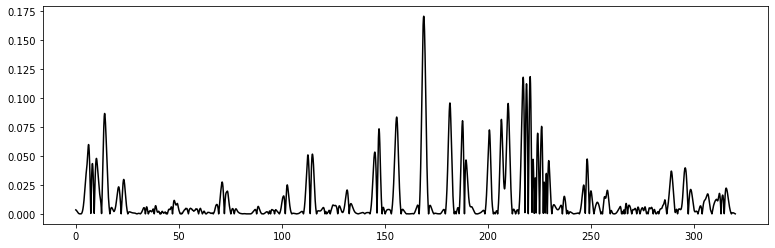

In [71]:
xlabel=np.arange(len(output[:,0])-1)/52
plt.figure(figsize=(13, 4))
plt.plot(xlabel,np.abs(np.diff(accel_filtered[:, 0])) ,c='k')
#plt.ylim(0,250)

In [72]:
# Low-pass filter to extract GA component (gravity)
def low_pass_filter(data, cutoff=0.25, fs=52.0, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Calculate the trunk angle in degrees (from gravity components y, z)
def calculate_trunk_angle(accel_y, accel_z):
    return np.degrees(np.arctan2(accel_z, accel_y))

# Signal vector magnitude (SVM) calculation
def calculate_svm(accel_data):
    return np.abs(np.sqrt(np.sum(accel_data**2, axis=1))-9.8)

# Detect walking, running, or prone crawling based on SVM thresholds and prone position
def detect_movement(svm_ga, accel_z, y_axis, walking_threshold=0.5, running_threshold=1, crawling_threshold=2):
    if svm_ga > running_threshold and svm_ga <3:
        return 'Running'
    elif svm_ga > walking_threshold and svm_ga <3:
        return 'Walking'
    elif accel_z > 0 and np.abs(y_axis) > crawling_threshold and np.abs(y_axis) <8:
        return 'Crawling (Prone)'
    else:
        return 'No movement'

# Detect rolling by checking large x-axis changes while lying
def detect_rolling(x_axis, lying_status, rolling_threshold=0.05):
    if lying_status and np.abs(np.diff(x_axis)).mean() > rolling_threshold:
        return 'Rolling'
    return 'Lying'

# Detect postural transitions using trunk angle changes
def detect_postural_transitions(trunk_angle, threshold=5):
    angle_change = np.abs(np.diff(trunk_angle))
    transitions = angle_change > threshold
    return transitions

In [73]:
# Define mapping from postures (strings) to integers
posture_mapping = {
    'Standing': 0,
    'Sitting': 1,
    'Lying': 2,
    'Prone': 3
}

# Define mapping from activities (strings) to integers
activity_mapping = {
    'Static': 0,
    'Walking': 1,
    'Running': 2,
    'Crawling': 3,
    'Rolling': 4
}

# Reverse mapping from integers back to postures and activities
reverse_posture_mapping = {v: k for k, v in posture_mapping.items()}
reverse_activity_mapping = {v: k for k, v in activity_mapping.items()}

# Main pipeline for activity detection
def activity_detection_pipeline(accel_data):
    # Step 1: Apply low-pass filter to extract gravity component
    accel_filtered = np.array([low_pass_filter(accel_data[:, i]) for i in range(3)]).T/100
    
    # Step 2: Calculate the trunk angle from gravity components
    trunk_angle = calculate_trunk_angle(accel_filtered[:, 1], accel_filtered[:, 2])
    
    # Step 3: Classify activities based on trunk angle and transitions
    postures = []
    transitions = detect_postural_transitions(trunk_angle)
    
    for i in range(len(trunk_angle)):
        if np.abs(trunk_angle[i]) <10:
            postures.append('Standing')
        elif np.abs(trunk_angle[i]) <70:
            postures.append('Sitting')
        #elif transitions[i-1] if i > 0 else False:
            #postures.append('Transition')
        else:
            if accel_filtered[i, 2] > 0:
                postures.append('Prone')
            else:
                postures.append('Lying')

    # Step 4: Walking/Running/Crawling/Rolling detection using SVM
    svm_ga = calculate_svm(accel_filtered)
    movement_labels = []
    for i in range(len(accel_filtered)):
        movement = detect_movement(svm_ga[i], accel_filtered[i, 2], accel_filtered[i, 1])
        if 'Prone' in postures[i]:
            if movement == 'Crawling (Prone)':
                movement_labels.append('Crawling')
            elif detect_rolling(accel_filtered[:, 0], postures[i] == 'Lying'):
                movement_labels.append('Rolling')
            else:
                movement_labels.append('Static')
        else:
            movement_labels.append(movement)

    # Step 5: Generate 2-second window labels (104 samples per 2-second window)
    window_size = 104 # 52Hz * 2 seconds
    posture_labels = []
    activity_labels = []

    for i in range(0, len(postures), window_size):
        window_postures = postures[i:i + window_size]
        window_movement = movement_labels[i:i + window_size]
        
        # Posture classification
        window_postures_int = [posture_mapping[p] for p in window_postures if p in posture_mapping]
        if len(window_postures_int) > 0:
            majority_posture = np.bincount(window_postures_int).argmax()
            posture_labels.append(reverse_posture_mapping[majority_posture])
        else:
            posture_labels.append('Unknown')

        # Activity classification
        if any('Running' in w for w in window_movement):
            activity_labels.append('Running')
        elif any('Walking' in w for w in window_movement):
            activity_labels.append('Walking')
        elif any('Crawling' in w for w in window_movement):
            activity_labels.append('Crawling')
        elif any('Rolling' in w for w in window_movement):
            activity_labels.append('Rolling')
        else:
            activity_labels.append('Static')

    return posture_labels, activity_labels

In [74]:
posture_labels, activity_labels = activity_detection_pipeline(output)
final_output=[]
for i in range(len(activity_labels)):
    if activity_labels[i]=='Static':
        final_output.append(posture_labels[i])
    else:
        final_output.append(activity_labels[i])

In [75]:
print(final_output)

['Walking', 'Walking', 'Running', 'Running', 'Walking', 'Crawling', 'Running', 'Running', 'Sitting', 'Standing', 'Standing', 'Standing', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Standing', 'Standing', 'Walking', 'Running', 'Running', 'Running', 'Running', 'Running', 'Standing', 'Walking', 'Walking', 'Walking', 'Walking', 'Sitting', 'Sitting', 'Standing', 'Standing', 'Standing', 'Standing', 'Standing', 'Standing', 'Standing', 'Standing', 'Sitting', 'Sitting', 'Standing', 'Standing', 'Walking', 'Walking', 'Standing', 'Standing', 'Standing', 'Standing', 'Standing', 'Crawling', 'Walking', 'Walking', 'Standing', 'Standing', 'Standing', 'Standing', 'Standing', 'Standing', 'Running', 'Running', 'Walking', 'Lying', 'Lying', 'Lying', 'Lying', 'Walking', 'Running', 'Lying', 'Lying', 'Walking', 'Running', 'Running', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Running', 'Running', 'Walking', 'Lying', 'Lying', 'Lying', 'Lying', 

In [76]:
True_labels=['Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking',
             'Walking', 'Standing', 'Standing', 'Standing', 'Standing', 'Standing', 'Standing', 'Standing', 'Standing', 'Standing',
             'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Running', 'Running', 'Running', 'Running', 'Running', 'Running', 'Running', 
             'Walking', 'Walking', 'Walking', 'Standing', 'Standing', 'Sitting', 'Sitting', 'Sitting', 'Standing', 'Standing', 'Standing', 'Standing',
             'Sitting', 'Sitting', 'Sitting', 'Standing', 'Standing', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Standing', 'Sitting',
             'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Standing', 'Standing', 'Standing', 'Walking', 'Walking', 'Walking',
             'Lying', 'Lying', 'Lying', 'Lying', 'Lying', 'Lying', 'Lying', 'Running', 'Running', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Running', 'Running', 
             'Lying', 'Lying', 'Lying', 'Lying', 'Lying', 'Sitting', 'Sitting', 'Standing', 'Standing', 'Crawling', 'Crawling', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 
             'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Rolling',
             'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Rolling', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Standing', 
             'Standing', 'Standing', 'Standing', 'Standing', 'Crawling', 'Crawling', 'Crawling', 'Crawling', 'Crawling', 'Crawling', 
             'Rolling', 'Rolling', 'Crawling', 'Crawling', 'Crawling', 'Crawling', 'Crawling', 'Crawling', 'Crawling', 'Crawling', 
             'Crawling', 'Crawling', 'Crawling', 'Walking', 'Standing', 'Standing', 'Running', 'Running', 'Lying', 'Lying']

In [77]:
labels=final_output

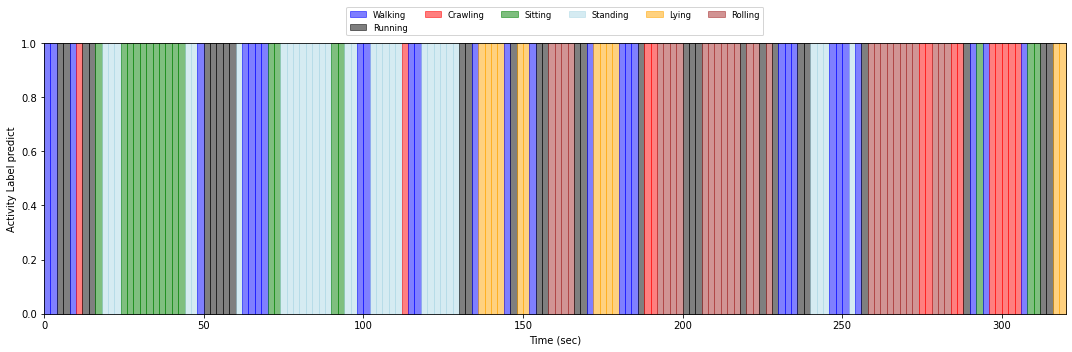

In [78]:
# Number of points each label covers
points_per_label = 2
label_colors = {
    'Running': 'black',
    'Walking': 'blue',
    'Standing': 'lightblue',
    'Sitting': 'green',
    'Crawling': 'red',
    'Lying': 'orange',
    'Rolling': 'brown',
    'Prone': 'Yellow'
    
}


# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Plot each label interval with the manually defined color
for i, label in enumerate(labels):
    start = i * points_per_label
    end = start + points_per_label
    ax.fill_betweenx([0, 1], start, end, color=label_colors[label], alpha=0.5, label=label if i == labels.index(label) else "")

# Set axis limits
ax.set_xlim(0, len(final_output)*2)
ax.set_ylim(0, 1)

# Add legend, avoiding duplicate entries
handles, labels_legend = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels_legend, handles)).values(), dict(zip(labels_legend, handles)).keys(),
          loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6, fontsize='small')

# Label axes
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Activity Label predict')

# Display the plot
plt.tight_layout()
plt.show()

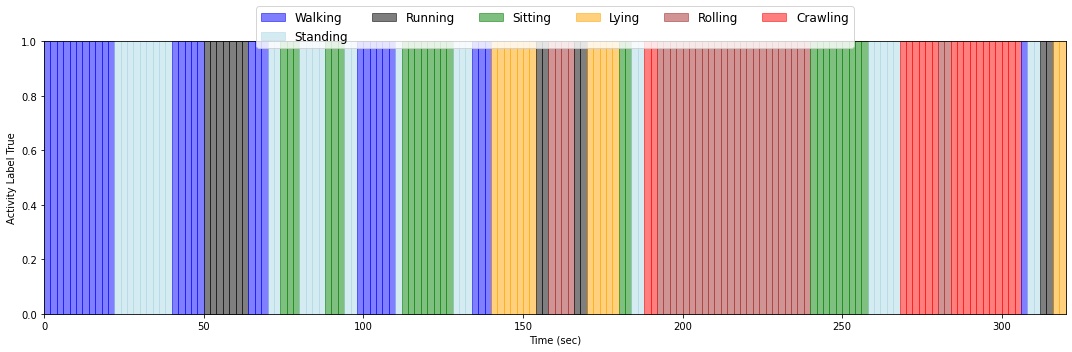

In [82]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 5))
label_colorsa = {
    'Running': 'black',
    'Walking': 'blue',
    'Standing': 'lightblue',
    'Sitting': 'green',
    'Crawling': 'red',
    'Lying': 'orange',
    'Rolling': 'brown',
    'Prone': 'Yellow'
    
}
# Plot each label interval with the manually defined color
for i, label in enumerate(True_labels):
    start = i * points_per_label
    end = start + points_per_label
    ax.fill_betweenx([0, 1], start, end, color=label_colorsa[label], alpha=0.5, label=label if i == True_labels.index(label) else "")

# Set axis limits
ax.set_xlim(0, len(True_labels)*2)
ax.set_ylim(0, 1)

# Add legend, avoiding duplicate entries
handles, labels_legend = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels_legend, handles)).values(), dict(zip(labels_legend, handles)).keys(),
          loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6, fontsize='large')
# Label axes
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Activity Label True')
# Display the plot
plt.tight_layout()
plt.show()